Objectives of the assignment

1. Implement linear regression models on dataset to predict a continuous output.

2. Use hypothesis testing to test the significance of individual predictors.

3. Implement polynomial regression to prove or disprove evidence of non-linear association between predictors.

4. Perform KNN Regression on the dataset

5. Link to the dataset: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


In [413]:
## Importing all the essential libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
%matplotlib inline

### Load the input data

In [414]:
#Loading the input data
data = pd.read_excel('https://github.com/GautamSPhadke/Datasets/blob/master/Folds5x2_pp.xlsx?raw=true',
                      'Sheet1')

### Display the number of rows and columns in the dataset

In [415]:
print('No. of rows equals:',data.shape[0])
print('No. of columns equals:',data.shape[1])

No. of rows equals: 9568
No. of columns equals: 5


In [416]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


#### There are 9568 rows and 5 columns in this data set. Rows represent a sample data point. For example, row 0 represents a data point with Ambient temperature = 14.96, Exhaust vacuum = 41.76, Ambient pressure = 1024.07, Relative humidity = 73.13, and energy output = 463.26. The columns represent feature vectors.

### Pairwise scatter plots between different predictors 

/home/gautam/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f6e69184c88> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


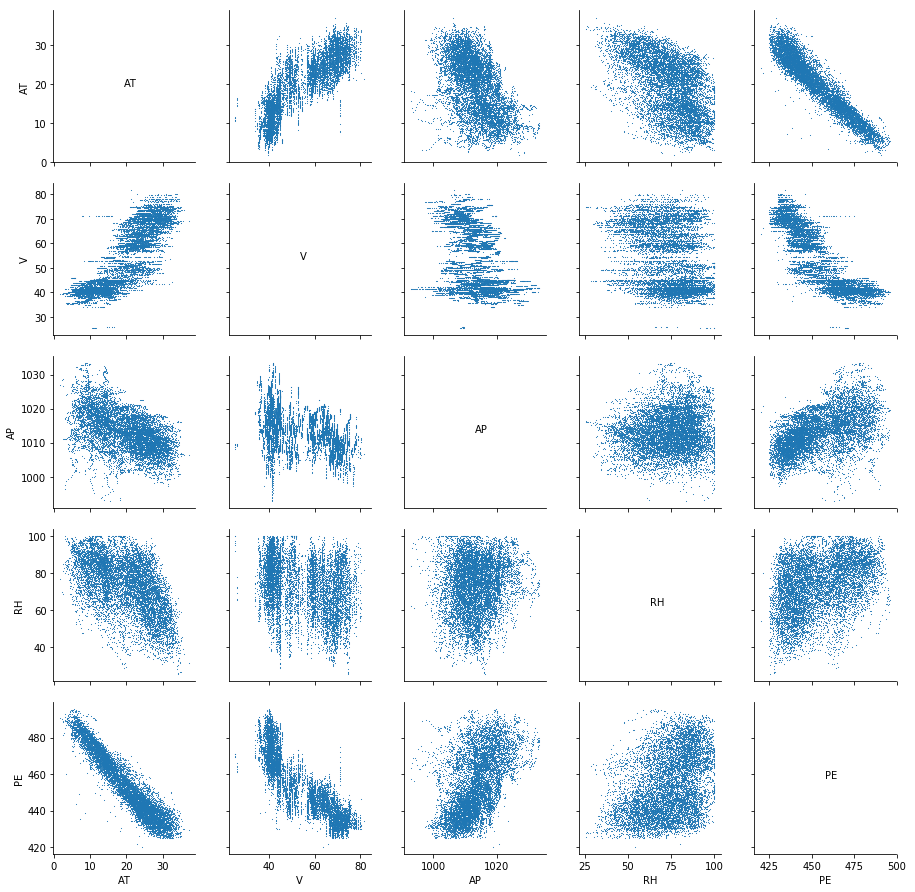

In [417]:
## Scatter plot
columns = ['AT','V','AP','RH','PE']
iterator = 0
def diagfunc(x, **kws):
    global iterator
    ax = plt.gca()
    ax.annotate(columns[iterator] ,xy=(0.5, 0.5), xycoords=ax.transAxes)
    iterator = iterator + 1
    
def scatter_plot(datafile):
    scatter_graph = sns.PairGrid(datafile).map_diag(diagfunc)
    scatter_graph = scatter_graph.map_offdiag(plt.scatter, linewidth = 0.5, s = 0.3)
    scatter_graph = scatter_graph.add_legend()
    
scatter_plot(data)

#### There appears to be a strong linear relationship between Ambient temperature and the target variable. Based on the graph, relationship of other feature vectors with the target variable does'nt appear to be strongly linear. Also, all the features don't appear to be correlated with each other, apart from AT and V which have some correlation between them.

### Important statistical information (eg. Mean, median, quartiles, etc) of the data

In [418]:
## Describe mean, median, etc. of the data
def data_description(data):
    data_description = data.describe()
    data_median = data.quantile([0.50])
    data_range = data.quantile([1.00]).rename(index = {1.0: 0}) - data.quantile([0.00]).rename(index = {0.0: 0})
    data_first_quantile = data.quantile([0.25])
    data_third_quantile = data.quantile([0.75])
    data_interquantile_range = data_third_quantile.rename(index = {0.75: 0}) - data_first_quantile.rename(index = {0.25:0})
    
    data_median = data_median.rename(index = {0.5: 'Median'})
    data_range = data_range.rename(index = {0: 'range'})
    data_first_quantile = data_first_quantile.rename(index = {0.25: 'first_quantile'})
    data_third_quantile = data_third_quantile.rename(index = {0.75: 'third_quantile'})
    data_interquantile_range = data_interquantile_range.rename(index = {0: 'interquantile_range'})
    
    data_mean = data.describe().loc['mean']
    data_mean = pd.DataFrame(data_mean)
    data_mean = data_mean.transpose()
    data_description = pd.concat([data_mean, data_median, data_range, data_first_quantile, data_third_quantile,
                             data_interquantile_range])
    
    return data_description

##  Mean, Median, range, first and third quartile, and interquartile ranges of every feature

In [419]:
data_description = data_description(data)

In [420]:
data_description.transpose()

,mean,Median,range,first_quantile,third_quantile,interquantile_range
AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,75.50,439.7500,468.43,28.6800


### Implementation of a simple Linear Regression model and calculate the statistical signifiance of individual features w.r.t target variable

In [421]:
#Creating individual feature vectors
label = data.iloc[:,4]
temperature = data.iloc[:,0]
vacuum = data.iloc[:,1]
pressure = data.iloc[:,2]
humidity = data.iloc[:,3]
temperature = pd.DataFrame(temperature)
vacuum = pd.DataFrame(vacuum)
pressure = pd.DataFrame(pressure)
humidity = pd.DataFrame(humidity)
features = pd.concat([temperature, vacuum, pressure, humidity], axis = 1)

In [422]:
def LinearRegScatterPlot(data_feature, data_label, prediction, xlabel):
    plt.scatter(data_feature, data_label, s = 0.5)
    plt.scatter(data_feature, prediction, s = 0.5)
    plt.xlabel(xlabel)
    plt.ylabel('Energy output')

def LinearReg(data_feature, data_label, xlabel):
    lr = LinearRegression()
    lr.fit(data_feature, data_label)
    prediction = lr.predict(data_feature)
    print(xlabel)
    print('R squared value is:', lr.score(data_feature, data_label))
    print('Intercept term is:', lr.intercept_)
    print('Coefficient term is:', lr.coef_)
    
    LinearRegScatterPlot(data_feature, data_label, prediction, xlabel)
    return lr.coef_
    

In [423]:
def statistical_model(data, string, label):
    stats_model = smf.ols(formula = string, data = data).fit()
    print('Summary of model for', label)
    print()
    model_summary = stats_model.summary().tables[1]
    print(model_summary)
    return stats_model
    

Summary of model for Ambient temperature

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    497.0341      0.156   3177.280      0.000     496.727     497.341
AT            -2.1713      0.007   -291.715      0.000      -2.186      -2.157

Temperature
R squared value is: 0.8989475964148236
Intercept term is: 497.03411989276674
Coefficient term is: [-2.17131996]


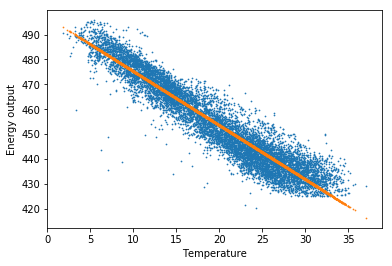

In [424]:
temperature_model = statistical_model(data, 'PE ~ AT', 'Ambient temperature')
print()
temp_univariate_coeff = LinearReg(temperature, label, 'Temperature')

## Energy output = 497.03 - 2.171*Temperature

Summary of model for Exhaust Vacuum

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.8015      0.378   1370.218      0.000     517.061     518.542
V             -1.1681      0.007   -172.402      0.000      -1.181      -1.155

Vacuum
R squared value is: 0.7565177870683979
Intercept term is: 517.801526308386
Coefficient term is: [-1.16813513]


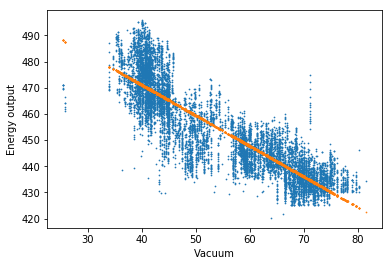

In [425]:
vacuum_model = statistical_model(data, 'PE ~ V', 'Exhaust Vacuum')
print()
vacuum_univariate_coeff = LinearReg(vacuum, label, 'Vacuum')

## Energy Output = 517.80 - 1.16*Exhaust_Vacuum

Summary of model for Ambient Pressure

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1055.2610     25.459    -41.449      0.000   -1105.167   -1005.355
AP             1.4899      0.025     59.296      0.000       1.441       1.539

Pressure
R squared value is: 0.2687686564110674
Intercept term is: -1055.2609889844396
Coefficient term is: [1.48987167]


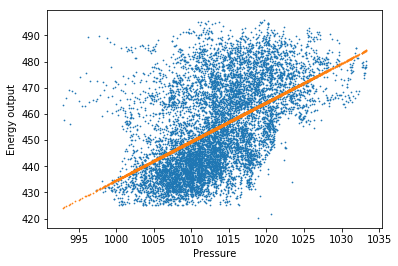

In [426]:
pressure_model = statistical_model(data, 'PE ~ AP', 'Ambient Pressure')
print()
pressure_univariate_coeff = LinearReg(pressure, label, 'Pressure')

## Energy Output = -1055.26 + 1.48*Ambient_Pressure

Summary of model for Relative Humidity

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    420.9618      0.823    511.676      0.000     419.349     422.574
RH             0.4557      0.011     41.399      0.000       0.434       0.477

Humidity
R squared value is: 0.15193944023117578
Intercept term is: 420.96176615548393
Coefficient term is: [0.4556501]


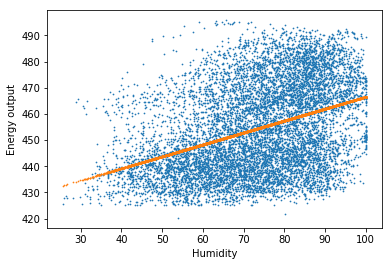

In [427]:
humidity_model = statistical_model(data, 'PE ~ RH', 'Relative Humidity')
print()
humidity_univariate_coeff = LinearReg(humidity, label, 'Humidity')

## Energy Output = 420.96 = 0.45*Relative_humidity

### As we can see from the above four tables, based on the p-values, all four features have a statistically significant association with the response variable. Also, AT and V are good univariate features for prediction of the output.

#### Remove the outliers based on z-scores

In [428]:
## Removal of outliers
def outlier_removal(features):
    z = np.abs(stats.zscore(features))
    features_new = features[(z < 2).all(axis=1)]
    return features_new

In [429]:
features_outlier_removed = outlier_removal(data)

In [430]:
features_outlier_removed.shape

(8606, 5)

In [431]:
features_outlier_removed.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67


Temperature after outlier removal
R squared value is: 0.8923726754463618
Intercept term is: [496.94106258]
Coefficient term is: [[-2.18130354]]


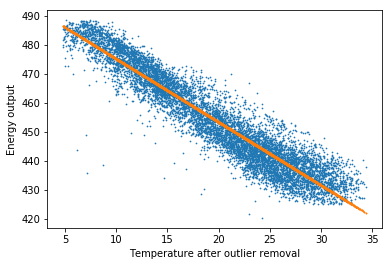

In [432]:
temp_univariate_coeff_outlier_removed = LinearReg(pd.DataFrame(features_outlier_removed.AT),
                                                  pd.DataFrame(features_outlier_removed.PE), 
                                                  'Temperature after outlier removal')

Vacuum after outlier removal
R squared value is: 0.7538389068632397
Intercept term is: [515.4648756]
Coefficient term is: [[-1.13062553]]


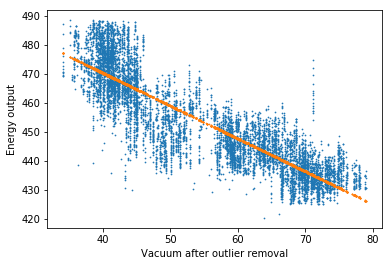

In [433]:
vacuum_univariate_coeff_outlier_removed = LinearReg(pd.DataFrame(features_outlier_removed.V),
                                                  pd.DataFrame(features_outlier_removed.PE),
                                                    'Vacuum after outlier removal')

Pressure after outlier removal
R squared value is: 0.26068322164326585
Intercept term is: [-1167.93724256]
Coefficient term is: [[1.60075541]]


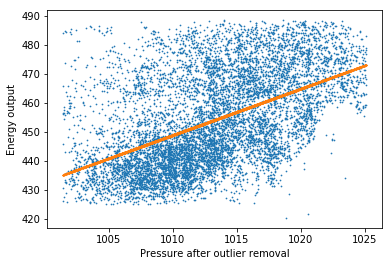

In [434]:
pressure_univariate_coeff_outlier_removed = LinearReg(pd.DataFrame(features_outlier_removed.AP),
                                                  pd.DataFrame(features_outlier_removed.PE), 
                                                      'Pressure after outlier removal')

Humidity after outlier removal
R squared value is: 0.13261442331743867
Intercept term is: [420.83614056]
Coefficient term is: [[0.44258271]]


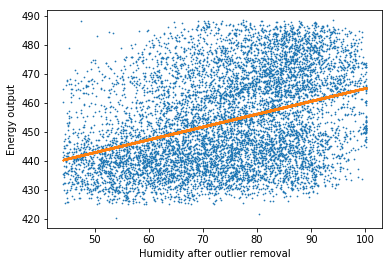

In [435]:
humidity_univariate_coeff_outlier_removed = LinearReg(pd.DataFrame(features_outlier_removed.RH),
                                                  pd.DataFrame(features_outlier_removed.PE),
                                                      'Humidity after outlier removal')

#### Outlier removal has been done on the basis of Z-score values. Thus, only the points with z-score < 2 have been retained. As we can observe from the above graph, there is no improvement in the R-squared values of each features before and after removing the outlier. Thus, we can avoid removing the outliers.

### Multivariate regression using statsmodel

In [436]:
## Multivariate regression
def combined_statistical_model(data, string, label):
    stats_model = smf.ols(formula = string, data = data).fit()
    print('Summary of model for', label)
    print()
    model_summary = stats_model.summary()
    print(model_summary)
    return stats_model

combined_feature_model = combined_statistical_model(data, 'PE ~ AT + V + AP + RH', 'Combined Features')

Summary of model for Combined Features

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:30   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

### R-squared value = 0.929. Also, As we can see from the above table, based on p-values of all the features, We have to reject null hypothesis for all the predictors.

### Comparison of coefficients: Univariate case vs Multivariate case

In [437]:
temp_multivariate_coeff = combined_feature_model.params.AT
vacuum_multivariate_coeff = combined_feature_model.params.V
pressure_multivariate_coeff = combined_feature_model.params.AP
humidity_multivariate_coeff = combined_feature_model.params.RH

In [438]:
temp_univariate_coeff = pd.DataFrame(temp_univariate_coeff)
vacuum_univariate_coeff = pd.DataFrame(vacuum_univariate_coeff)
pressure_univariate_coeff = pd.DataFrame(pressure_univariate_coeff)
humidity_univariate_coeff = pd.DataFrame(humidity_univariate_coeff)


In [439]:
df_multivariate = pd.DataFrame({0:[temp_multivariate_coeff, vacuum_multivariate_coeff, pressure_multivariate_coeff,
                      humidity_multivariate_coeff]}, index = ['temperature','vacuum','pressure','humidity'])

In [440]:

df_univariate = pd.concat([temp_univariate_coeff, vacuum_univariate_coeff, pressure_univariate_coeff,
                          humidity_univariate_coeff])

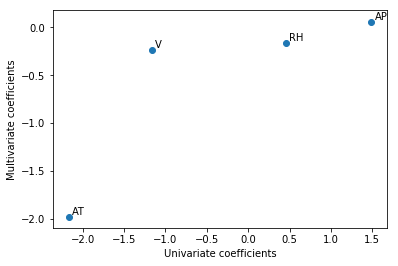

In [441]:
variables = ['AT','V','AP','RH']
plt.scatter(df_univariate, df_multivariate)
plt.xlabel('Univariate coefficients')
plt.ylabel('Multivariate coefficients')

for i, text in enumerate(variables):
    plt.annotate(text, (df_univariate.iloc[i] + 0.04, df_multivariate.iloc[i]+0.02 ))

###  R-squared value for only temperature = 0.89, only vacuum = 0.75, only pressure = 0.26 and only humidity = 0.15. R-squared value for combined model = 0.929. Thus, we can clearly observe that a linear model with all four features combined performs better compared to the model where all four features are individually used. Thus, multivariate regression is a better option compared to univariate regression for this dataset.

### Find whether there is any evidence of non-linear association between the predictors and the target variables.

In [442]:
def nonlinear_association(feature, label, description):
    poly = PolynomialFeatures(degree = 3)
    feature_dataframe = pd.DataFrame(poly.fit_transform(feature))
    feature_dataframe = feature_dataframe.drop(columns = [0])
    feature_dataframe = pd.concat([feature_dataframe, pd.DataFrame(label)], axis = 1)
    feature_dataframe = feature_dataframe.rename(columns = {1: 'deg1', 2: 'deg2', 3:'deg3'})
    
    combined_statistical_model(feature_dataframe, 'PE ~ deg1 + deg2 + deg3', description)

#### Polynomial model for temperature

In [443]:
nonlinear_association(temperature, label, 'Polynomial model for temperature')

Summary of model for Polynomial model for temperature

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:31   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### R-squared for linear model for temperature = 0.89. R-squared for polynomial model for temperature = 0.91

### Polynomial model for vacuum

In [444]:
nonlinear_association(vacuum, label, 'Polynomial model for vacuum')

Summary of model for Polynomial model for vacuum

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:31   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

### R-squared for linear model for vacuum = 0.75. R-squared for polynomial model for vacuum = 0.77

### Polynomial model for pressure

In [445]:
nonlinear_association(pressure, label, 'Polynomial model for presssure')

Summary of model for Polynomial model for presssure

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:31   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

### R-squared for linear model of pressure = 0.26. R-squared for polynomial model of pressure = 0.275

### Polynomial model for humidity

In [446]:
nonlinear_association(humidity, label, 'Polynomial model for humidity')

Summary of model for Polynomial model for humidity

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:31   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


### R-squared for linear model of humidity = 0.13. R-squared for polynomial model of humidity = 0.154

### As we can see from the above results, there is a evidence nonlinear association between predictors and response, except for Vacuum^2 term, which is statistically insignificant due to high p value.

### Find whether there exists evidence of pairwise interaction of predictors 

In [447]:
def pairwise_interaction(data):
    label = data.iloc[:,4]
    temperature = data.iloc[:,0]
    vacuum = data.iloc[:,1]
    pressure = data.iloc[:,2]
    humidity = data.iloc[:,3]
    temperature = pd.DataFrame(temperature)
    vacuum = pd.DataFrame(vacuum)
    pressure = pd.DataFrame(pressure)
    humidity = pd.DataFrame(humidity)
    
    poly = PolynomialFeatures(degree = 2, interaction_only = True)
    features = pd.concat([temperature, vacuum, pressure, humidity], axis = 1)
    features_new = pd.DataFrame(poly.fit_transform(features))
    features_new = features_new.drop(columns = [0])
    features_new.rename(columns = {1:'AT', 2: 'V', 3: 'AP', 4: 'RH', 5: 'AT*V', 6: 'AT*AP' , 7: 'AT*RH',
                              8: 'V*AP', 9: 'V*RH', 10: 'AP*RH'}, inplace = True)
    
    features_new = pd.concat([features_new, pd.DataFrame(label)], axis = 1)
    
    return features_new 

In [448]:
features_new = pairwise_interaction(data)
combined_statistical_model(features_new, 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH',
                      'Model of interaction terms')

Summary of model for Model of interaction terms

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:31   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Int

### R-squared value = 0.936. There is evidence of association of interactions as we can see from p-values of the above table. However, ATxAP, VxRH and APxRH are statistically insignificant, where as ATxV, VxAP, and APxRH are statistically significant. 

### Remove insignificant terms 

In [449]:
## Creating polynomial features
def polynomial_data(feature, column_name):
    poly = PolynomialFeatures(degree = 2)
    feature_dataframe = pd.DataFrame(poly.fit_transform(feature))
    feature_dataframe = feature_dataframe.drop(columns = [0,1])
    feature_dataframe.rename(columns = {2: column_name}, inplace = True)
    return feature_dataframe      

In [450]:
temperature_square = polynomial_data(temperature, 'ATsquared')
vacuum_square = polynomial_data(vacuum, 'Vsquared')
pressure_square = polynomial_data(pressure, 'APsquared')
humidity_square = polynomial_data(humidity, 'RHsquared')

In [451]:
combined_data = pd.concat([features_new, temperature_square, vacuum_square, pressure_square, humidity_square], 
                         axis = 1)

In [452]:
combined_features = combined_data.drop(columns = ['PE'])

In [453]:
original_feature_set = pd.concat([temperature, vacuum, pressure, humidity], axis = 1)    

In [454]:
ones = pd.DataFrame(np.ones(shape = (len(label), 1)))
ones = ones.rename(columns = {0: 'Intercept'})
final_feature_set = pd.concat([ones, original_feature_set], axis = 1)
final_combined_set = pd.concat([ones, combined_features], axis = 1)

In [455]:
## Shape of features with combined data
final_combined_set.shape

(9568, 15)

In [456]:
feature_train, feature_test, label_train, label_test = train_test_split(final_feature_set, label, 
                                                                       test_size = 0.3, random_state = 42) 

In [457]:
##Shape of features with simple data
feature_train.shape, feature_test.shape, label_train.shape, label_test.shape

((6697, 5), (2871, 5), (6697,), (2871,))

In [458]:
combined_feature_train, combined_feature_test, label_train, label_test = train_test_split(final_combined_set, label,
                                                                                         test_size = 0.3,
                                                                                         random_state =  42)

In [459]:
combined_feature_train.shape, combined_feature_test.shape, label_train.shape, label_test.shape

((6697, 15), (2871, 15), (6697,), (2871,))

In [460]:
def regression_model(feature_train, feature_test, label_train, label_test):
    stats_model = smf.OLS(label_train, feature_train).fit()
    print(stats_model.summary())
    predicted_value_train = stats_model.predict(feature_train)
    predicted_value_test = stats_model.predict(feature_test)
    print()
    print('Mean squared training error = ',mean_squared_error(label_train, predicted_value_train))
    print('Mean squared test error = ', mean_squared_error(label_test, predicted_value_test))

### Multivariate regression with simple features

In [461]:
regression_model(feature_train, feature_test, label_train, label_test)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.194e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:33   Log-Likelihood:                -19630.
No. Observations:                6697   AIC:                         3.927e+04
Df Residuals:                    6692   BIC:                         3.930e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    467.8414     11.502     40.673      0.0

### Multivariate regression with polynomial and interaction terms

In [462]:
regression_model(combined_feature_train, combined_feature_test, label_train, label_test)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7272.
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:33   Log-Likelihood:                -19160.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6682   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7664.9809   1429.568     -5.362      0.0

In [463]:
final_combined_set_modified = final_combined_set.drop(columns = ['Vsquared','V*RH','V*AP','AT*AP'])

In [464]:
combined_feature_train_modified, combined_feature_test_modified, label_train, label_test = train_test_split(final_combined_set_modified,
                                                                                                           label, test_size = 0.3,
                                                                                                           random_state = 42)

### Multivariate regression after removing insignificant terms

In [465]:
regression_model(combined_feature_train_modified, combined_feature_test_modified, label_train, label_test)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.017e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:17:33   Log-Likelihood:                -19166.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6686   BIC:                         3.843e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.046e+04   1091.512     -9.581      0.0

### Yes, the model can be improved with using polynomial and interaction terms, as is evident from the MSE's of both the models

### Use KNN Regression

In [466]:
## Knn regression
def line_plot(training_error_list, test_error_list):
    range_of_k = [1/i for i in range(1,101,1)]
    plt.plot(range_of_k, training_error_list, label = 'training_error')
    plt.plot(range_of_k, test_error_list, label = 'test_error')
    plt.gca().legend(('training_error','test_error'))
    plt.xlabel('1/k')
    plt.ylabel('Error value')

def knn_regression(feature_train, feature_test, label_train, label_test, title):
    training_error_list = []
    test_error_list = []
    for k in range(1,101,1):
        knn = KNeighborsRegressor(n_neighbors = k)
        knn = knn.fit(feature_train, label_train)
        predict_train = knn.predict(feature_train)
        predict_test = knn.predict(feature_test)
        training_error = 1 - knn.score(feature_train, label_train)
        test_error = 1 - knn.score(feature_test, label_test)
        
        training_error_list.append(training_error)
        test_error_list.append(test_error)
        
    print(title)
    print()
        
    print('Best fit error = ', min(test_error_list))
    min_k = test_error_list.index(min(test_error_list)) + 1
    print('Value of k for best fit = ', min_k)
    
    line_plot(training_error_list, test_error_list)
        

In [467]:
feature_train_knn, feature_test_knn, label_train, label_test = train_test_split(original_feature_set,
                                                                               label,
                                                                               test_size = 0.3,
                                                                               random_state = 42)

### Simple Knn Regression model

KNN Regression model for raw features

Best fit error =  0.05364592369711796
Value of k for best fit =  5


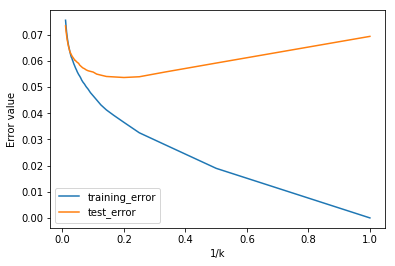

In [468]:
knn_regression(feature_train_knn, feature_test_knn, label_train, label_test, 'KNN Regression model for raw features')

In [469]:
min_max = MinMaxScaler()
feature_train_normalized = min_max.fit_transform(feature_train_knn)
feature_test_normalized = min_max.transform(feature_test_knn)

### Knn regression with normalized data

KNN regression model for normalized features

Best fit error =  0.04874932061664583
Value of k for best fit =  4


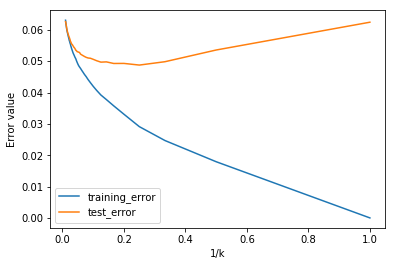

In [470]:
knn_regression(feature_train_normalized, feature_test_normalized, label_train, label_test, 
               'KNN regression model for normalized features')

In [471]:
best_test_error_table = pd.DataFrame(columns = ['Model used', 'best test error rate value'],
                                     index = ['1','2','3','4'])
simple_regression_model = {'Model used': 'Multivariate regression', 'best test error rate value': 0.071}
interaction_regression_model = {'Model used':'Regression using interaction terms', 'best test error rate value':0.062}
knn_regressor = {'Model used' : 'Simple knn regression', 'best test error rate value': 0.053}
knn_normalized = {'Model used': 'Normalized knn regression', 'best test error rate value' : 0.048}

In [472]:
best_test_error_table.loc['1'] = pd.Series(simple_regression_model)
best_test_error_table.loc['2'] = pd.Series(interaction_regression_model)
best_test_error_table.loc['3'] = pd.Series(knn_regressor)
best_test_error_table.loc['4'] = pd.Series(knn_normalized)

In [473]:
best_test_error_table

,Model used,best test error rate value
1,Multivariate regression,0.071
2,Regression using interaction terms,0.062
3,Simple knn regression,0.053
4,Normalized knn regression,0.048


### Question (j) Comparison of results: As we can see from the above results, the data normalized version of knn regression provides us with best results. knn regression produces is a non-linear model, which captures the non-linearity better compared to linear models like Multivariate regression. Also, due to high availibility of data and low dimensionality, knn regressor model does not tend to overfit. Thus, for our given data, normalized data version of knn regression performs better compared to all other models used.

### (Introduction to Statistical Learning 2.4.1)

ans (a). Flexible statistical learning method would perform better as compared to inflexible one. Due to a large sample size and small number of predictors, more parameters can be fitted on the data without the risk of overfitting the data.

ans (b). Flexible statistical learning method would perform worse as compared to inflexible one. As the sample size is small, but dimensionality of the data is high, a flexible method is more prone to overfitting the data as compared to an inflexible one. 

ans (c). Flexible statistical learning method would perform better as compared to inflexible one. A flexible model is better in capturing the non-linear relationship between predictors and response compared to an inflexible one. For example, if the relationship is highly non-linear, a polynomial of degree 10 would fit the data better compared to a polynomial of degree 2.

ans (d). Flexible statistical learning method would perform worse as compared to inflexible one. Because of the high variance in the error terms, a flexible model will try to tune it's parameters so as to capture this variance. This would lead to overfitting. 

### (Introduction to Statistical Learning 2.4.7)

In [474]:
x1 = pd.DataFrame([0,2,0,0,-1,1])
x1.rename(columns = {0:'X1'}, inplace = True)
x2 = pd.DataFrame([3,0,1,1,0,1])
x2.rename(columns = {0:'X2'}, inplace = True)
x3 = pd.DataFrame([0,0,3,2,1,1])
x3.rename(columns = {0:'X3'}, inplace = True)
Y = pd.DataFrame(['Red','Red','Red','Green','Green','Red'])
Y.rename(columns = {0:'Y'}, inplace = True)
observations = pd.concat([x1,x2,x3,Y], axis = 1)


In [475]:
observations

,X1,X2,X3,Y
0,0,3,0,Red
1,2,0,0,Red
2,0,1,3,Red
3,0,1,2,Green
4,-1,0,1,Green
5,1,1,1,Red


In [476]:
from sklearn.metrics.pairwise import euclidean_distances

In [477]:
features = observations.drop(columns = ('Y'))

In [478]:
euclidean_distance = pd.DataFrame(euclidean_distances(features, [[0, 0, 0]]))
euclidean_distance.rename(columns = {0: 'Euclidean distance'}, inplace = True)

In [479]:
euclidean_distance_label = pd.concat([euclidean_distance, Y], axis = 1)

(a) Euclidean distance between each observation and test point

In [480]:
euclidean_distance_label

,Euclidean distance,Y
0,3.000000,Red
1,2.000000,Red
2,3.162278,Red
3,2.236068,Green
4,1.414214,Green
5,1.732051,Red


(b) If K = 1, The prediction for point [0,0,0] will be Green. This is because the sample [-1, 0, 1], whose label is green, is at the shortest distance of 1.414 from our prediction point.

(c) If K = 3, we have to select three nearest points to our point with co-ordinated [0,0,0]. The three nearest points are point [-1,0,1] with label Green, point [1,1,1] with label red, and point [2,0,0] with label Red. Thus, our prediction point will also have the label Red.

(d) When the value of K increases, the decision boundary becomes more rigid. Thus, if the problem is non-linear, it will be better to have a small value of K.